# Day2_work 

## 選択課題

kickstarter-projects

## 目的変数と説明変数の関係を分析

In [1]:
import time
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score

#### データの読み込み
5000件のデータでサンプリング分析を行う

In [2]:
eda_df_kick = pd.read_csv("kickstarterProjects/ks-projects-201801.csv", nrows=5000)

#### ks-projects-201801.csvの総合的な情報を表示

In [3]:
print(eda_df_kick.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
ID                  5000 non-null int64
name                5000 non-null object
category            5000 non-null object
main_category       5000 non-null object
currency            5000 non-null object
deadline            5000 non-null object
goal                5000 non-null float64
launched            5000 non-null object
pledged             5000 non-null float64
state               5000 non-null object
backers             5000 non-null int64
country             5000 non-null object
usd pledged         4947 non-null float64
usd_pledged_real    5000 non-null float64
usd_goal_real       5000 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 586.0+ KB
None


#### 項目ごとの分析指針

|項目名  |名称　|型  |分析指針　|
|---|---|---|---|
|ID  |内部ID |数値 |対象外 |
| name | プロジェクトの名前 |　文字列 |　対象外 |
| category | カテゴリー |　　文字列 |　カテゴリ変数として分析 |
| main_category | キャンペーンのカテゴリ |　　文字列 | カテゴリ変数として分析 |
| currency | サポートする通貨 |　　文字列 |　通貨別のstateを確認 |
| deadline | クラウドファンディングの締め切り |　日付 |今回は対象外 |
| goal | 資金調達目標　 |　数値 |　対象外(usd_goal_real を利用) |
| launched | 開始日 |　日付 |　今回は対象外 |
| pledged | 資金調達金額|　数字 |　対象外 |
| state | プロジェクトの現在の状態 |　文字列 |目的変数。ただし成功するか否かなので二値化する |
| backers | 支持者数 |　数字 |　対象 |
| country | 支持者の国籍 |　文字列 |　カテゴリ変数として分析 |
| usd pledged | 資金調達金額(USD換算) ※キックスタータによる換算　|　数字 |　対象外 |
| usd_pledged_real | 資金調達金額(USD換算) ※Fixer.io APIによるの換算　| 数字 | 対象外 |
| usd_goal_real | 資金調達目標(USD換算) ※Fixer.io APIによるの換算　| 数字 | 対象 |

#### ks-projects-201801.csvのヘッダ情報(最初の5行)を表示

In [4]:
eda_df_kick.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


#### 数値データに対して各種統計量を計算

In [5]:
eda_df_kick.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,5.000000e+03,5.000000e+03,5.000000e+03,5000.000000,4.947000e+03,5.000000e+03,5.000000e+03
mean,9.197542e+08,3.705205e+04,1.078875e+04,109.281400,6.447518e+03,1.034009e+04,2.861168e+04
std,2.782873e+08,6.202375e+05,1.065725e+05,800.462044,4.268747e+04,1.063973e+05,2.812633e+05
min,1.003381e+06,1.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,9.100000e-01
25%,1.004020e+09,2.000000e+03,3.500000e+01,2.000000,2.000000e+01,3.459500e+01,2.000000e+03
50%,1.011616e+09,5.000000e+03,6.700000e+02,12.500000,4.300000e+02,6.589400e+02,5.000000e+03
75%,1.018699e+09,1.500000e+04,4.351250e+03,57.000000,3.157500e+03,4.238750e+03,1.504015e+04
max,1.025517e+09,4.000000e+07,4.809548e+06,36863.000000,2.344135e+06,5.020667e+06,1.710454e+07


#### 欠損値の有無を確認

In [6]:
eda_df_kick.isnull().any(axis=0)

ID                  False
name                False
category            False
main_category       False
currency            False
deadline            False
goal                False
launched            False
pledged             False
state               False
backers             False
country             False
usd pledged          True
usd_pledged_real    False
usd_goal_real       False
dtype: bool

欠損地があるのは name, use pledged　のみ

#### 相関関係を各員

In [7]:
corr_mat = eda_df_kick[['goal','backers','usd_goal_real']].corr()
corr_mat

,goal,backers,usd_goal_real
goal,1.000000,0.000580,0.502335
backers,0.000580,1.000000,0.005492
usd_goal_real,0.502335,0.005492,1.000000


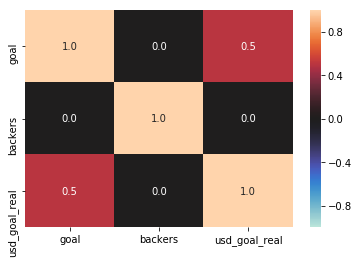

In [8]:
sns.heatmap(corr_mat,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            annot=True, # True:格子の中に値を表示
            fmt='.1f',
            xticklabels=corr_mat.columns.values,
            yticklabels=corr_mat.columns.values
           )
plt.show()

goalとusd_goal_realの相関性は高くないので、双方とも説明変数とする

### 文字データの分布を確認

#### カテゴリ
カテゴリ別にstateを積み上げ棒グラフで表示

In [9]:
category_vc = eda_df_kick['category'].value_counts()
print('カテゴリの数:', category_vc.count())

カテゴリの数: 155


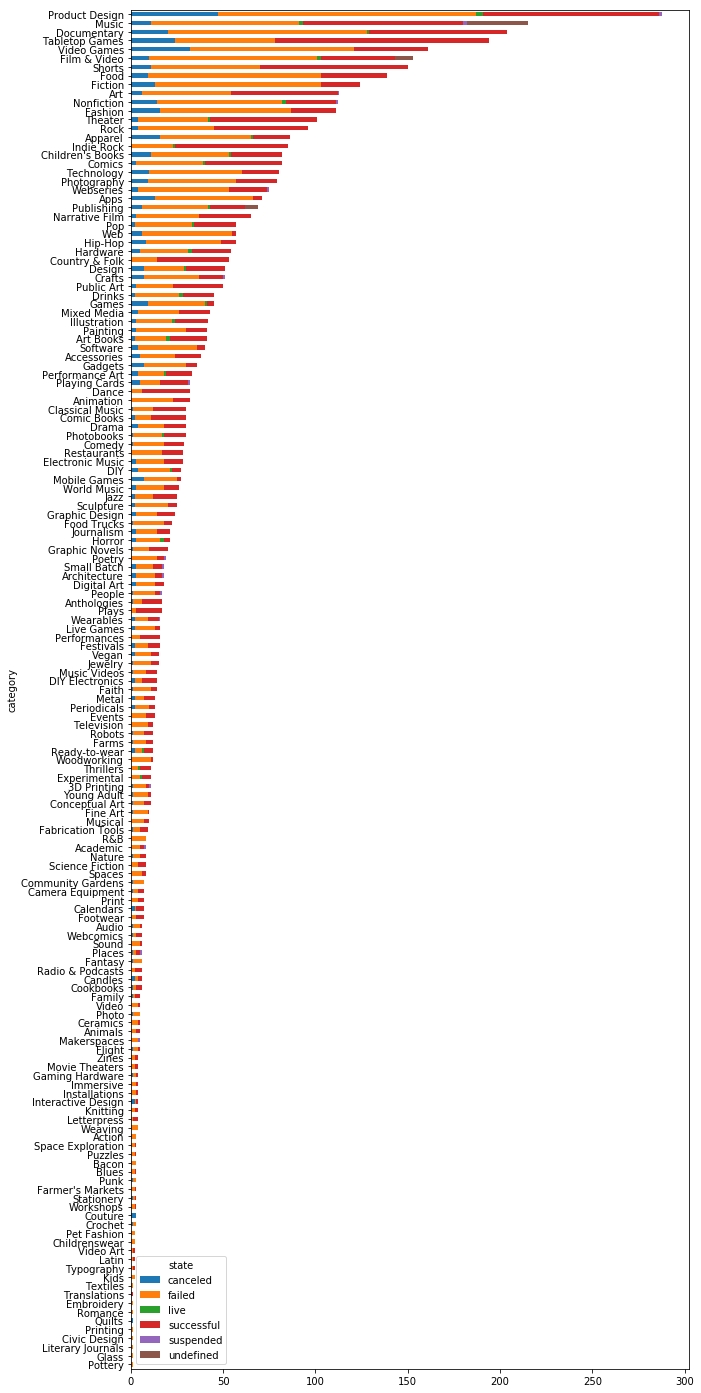

In [10]:
# category_vc.sort_values(ascending=True).plot(kind="barh",figsize=(10,30))
ct = pd.crosstab(eda_df_kick['category'], eda_df_kick['state'])
ct['sum'] = ct['canceled'] +  ct['failed'] +  ct['live'] +  ct['successful'] +  ct['suspended'] +  ct['undefined']
ct = ct.sort_values(by=["sum"], ascending=True)
ct[['canceled','failed','live','successful','suspended','undefined']].plot(kind='barh',stacked=True,figsize=(10,25))

#### メインカテゴリ
メインカテゴリ別にstateを積み上げ棒グラフで表示

In [11]:
vc = eda_df_kick['main_category'].value_counts()
print('メインカテゴリの数:', vc.count())

メインカテゴリの数: 15


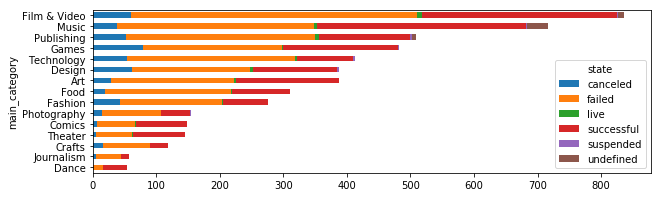

In [12]:
ct = pd.crosstab(eda_df_kick['main_category'], eda_df_kick['state'])
ct['sum'] = ct['canceled'] +  ct['failed'] +  ct['live'] +  ct['successful'] +  ct['suspended'] +  ct['undefined']
ct = ct.sort_values(by=["sum"], ascending=True)
ct[['canceled','failed','live','successful','suspended','undefined']].plot(kind='barh',stacked=True,figsize=(10,3))

#### 通貨別

In [13]:
vc = eda_df_kick['currency'].value_counts()
print('通貨種類の数:', vc.count())

通貨種類の数: 13


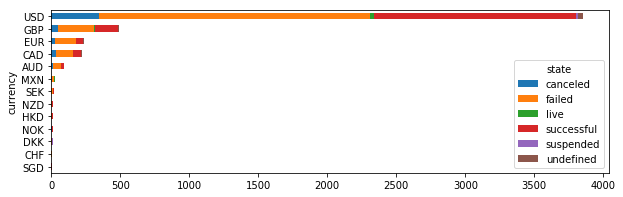

In [14]:
ct = pd.crosstab(eda_df_kick['currency'], eda_df_kick['state'])
ct['sum'] = ct['canceled'] +  ct['failed'] +  ct['live'] +  ct['successful'] +  ct['suspended'] +  ct['undefined']
ct = ct.sort_values(by=["sum"], ascending=True)
ct[['canceled','failed','live','successful','suspended','undefined']].plot(kind='barh',stacked=True,figsize=(10,3))

上位5通貨の比率

In [15]:
((eda_df_kick['currency'] =='USD').sum() + (eda_df_kick['currency'] =='GBP').sum() + (eda_df_kick['currency'] =='EUR').sum() + \
 (eda_df_kick['currency'] =='CAD').sum() + (eda_df_kick['currency'] =='AUD').sum()) / eda_df_kick['name'].count()

0.978

支援者の母国別

In [16]:
vc = eda_df_kick['country'].value_counts()
print('支援者の母国の数:', vc.count())

支援者の母国の数: 22


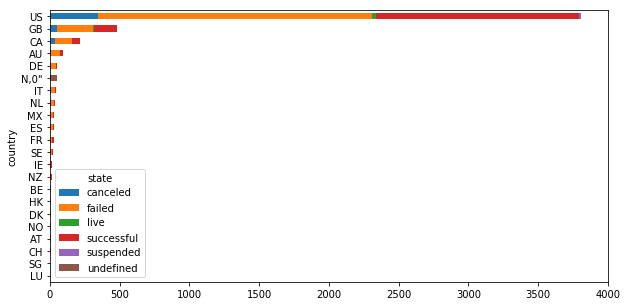

In [17]:
ct = pd.crosstab(eda_df_kick['country'], eda_df_kick['state'])
ct['sum'] = ct['canceled'] +  ct['failed'] +  ct['live'] +  ct['successful'] +  ct['suspended'] +  ct['undefined']
ct = ct.sort_values(by=["sum"], ascending=True)
ct[['canceled','failed','live','successful','suspended','undefined']].plot(kind='barh',stacked=True,figsize=(10,5))

##### 各説明変数の分析所感）　　
特に問題はないと思われるため、説明変数として利用する

## 有効な説明変数

今回、対象外とした項目を削除

In [18]:
df_kick = pd.read_csv("kickstarterprojects/ks-projects-201801.csv")
df_kick = df_kick.drop(["ID",'name','deadline','launched','pledged','usd pledged','usd_pledged_real'], axis=1)

#### カテゴリ変数をダミー変数に変換

In [19]:
df_kick1 = pd.get_dummies(df_kick['category'])
df_kick2 = pd.get_dummies(df_kick['country'])
df_kick3 = pd.get_dummies(df_kick['main_category'])
df_kick4 = pd.get_dummies(df_kick['currency'])

In [20]:
df_kick = pd.merge(df_kick,df_kick1,left_index=True, right_index=True)
df_kick = pd.merge(df_kick,df_kick2,left_index=True, right_index=True)
df_kick = pd.merge(df_kick,df_kick3,left_index=True, right_index=True)
df_kick = pd.merge(df_kick,df_kick4,left_index=True, right_index=True)
df_kick = df_kick.drop(['category','country','main_category','currency'], axis=1)
df_kick

,goal,state,backers,usd_goal_real,3D Printing,Academic,Accessories,Action,Animals,Animation,...,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
0,1000.0,failed,0,1533.95,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,30000.0,failed,15,30000.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,45000.0,failed,3,45000.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,5000.0,failed,1,5000.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,19500.0,canceled,14,19500.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,50000.0,successful,224,50000.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,1000.0,successful,16,1000.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,25000.0,failed,40,25000.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,125000.0,canceled,58,125000.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,65000.0,canceled,43,65000.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## ロジステック回帰の実装（Day1の内容)

In [21]:
def print_recall_precesion(conf_mat):
    tp = conf_mat.values[0,0]
    fp = conf_mat.values[0,1]
    fn = conf_mat.values[1,0]
    tn = conf_mat.values[1,1]
    recall = tp/(tp+fn)
    precesion = tp/(tp+fp)
    print('Recall = {:.3f}'.format(recall))
    print('Precesion = {:.3f}'.format(precesion))

In [22]:
y = df_kick['state'].values
y = np.where(df_kick['state'].values=='successful', 1,0)
X = df_kick.drop('state', axis=1).values
sum(y == 1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
clf = SGDClassifier(loss='log', penalty='none', max_iter=100, fit_intercept=True, random_state=1234)
clf.fit(x_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=100, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=1234,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [24]:
# ラベルを予測
y_est = clf.predict(x_test)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est)))

対数尤度 = -3.290
正答率 = 90.476%


In [25]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix( y_est,y_test), 
                        index=['予測 = プロジェクト成功以外', '予測 = プロジェクト成功'], 
                        columns=['正解 = プロジェクト成功以外', '正解 = プロジェクト成功'])
conf_mat

,正解 = プロジェクト成功以外,正解 = プロジェクト成功
予測 = プロジェクト成功以外,43381,1598
予測 = プロジェクト成功,5615,25139


In [26]:
print_recall_precesion(conf_mat)

Recall = 0.885
Precesion = 0.964


## ロジステック回帰 (Day 2 )
標準化を行い、Day1と比較する

In [27]:
# 標準化の方法を確認
z =np.array([[1.,2.,3.,4.],[1.,2.,5.,4.],[3.,2.,6.,4.],[1.,4.,3.,4.],[1.,2.,5.,4.],[1.,2.,3.,4.]])
print(z)
scaler = StandardScaler()
z[:,0:3] = scaler.fit_transform(z[:,0:3])
print(z)

[[1. 2. 3. 4.]
 [1. 2. 5. 4.]
 [3. 2. 6. 4.]
 [1. 4. 3. 4.]
 [1. 2. 5. 4.]
 [1. 2. 3. 4.]]
[[-0.4472136  -0.4472136  -0.96152395  4.        ]
 [-0.4472136  -0.4472136   0.68680282  4.        ]
 [ 2.23606798 -0.4472136   1.5109662   4.        ]
 [-0.4472136   2.23606798 -0.96152395  4.        ]
 [-0.4472136  -0.4472136   0.68680282  4.        ]
 [-0.4472136  -0.4472136  -0.96152395  4.        ]]


In [28]:
sx_train = x_train.copy()
sx_test  = x_test.copy()
scaler    = StandardScaler()

# トレーニングデータの各行の最初3列を標準化
sx_train[:,0:3] = scaler.fit_transform(sx_train[:,0:3])

# トレーニングデータの統計情報を元にテストデータの各行の最初の３列を標準化する
sx_test[:,0:3] = scaler.transform(sx_test[:,0:3])

In [29]:
# fitへのパラメータ
np.set_printoptions(threshold=0)
np.set_printoptions(edgeitems=6)
print('sx_train=',sx_train)
print('y_train=',y_train)

sx_train= [[ 1.25198204e-03 -1.11815501e-01  3.95534825e-03  0.00000000e+00
   0.00000000e+00  0.00000000e+00 ...  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [-3.81643346e-02  1.62623386e-01 -3.54973911e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00 ...  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.47367982e-02 -1.12883357e-01 -2.23973152e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00 ...  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [-3.81643346e-02 -1.12883357e-01 -3.60128579e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00 ...  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [-3.51323102e-02 -1.05408368e-01 -3.29383805e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00 ...  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000

In [30]:
clf = SGDClassifier(loss='log', penalty='none', max_iter=100, fit_intercept=True, random_state=1234)
clf.fit(sx_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=100, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=1234,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [31]:
print("clf.coef_=",clf.coef_)

clf.coef_= [[-56.85876927  28.7629591  -68.19837674   0.742896    -0.21834254
    0.20120721 ...   0.4272975    0.24951879  -0.40727415  -0.38778592
   -0.34063839  -0.65634419]]


In [32]:
# predict　へのパラメータ
print('sx_test=',sx_test)

sx_test= [[-0.0247368   0.0419557  -0.02239732  0.          0.          0.
  ...  0.          0.          0.          0.          0.
   1.        ]
 [-0.02906826  0.01632717 -0.02678943  0.          0.          0.
  ...  0.          0.          0.          0.          0.
   1.        ]
 [ 0.00125198 -0.10327266  0.00395535  0.          0.          0.
  ...  0.          0.          0.          0.          0.
   1.        ]
 [ 0.00991491 -0.10113695  0.02826651  0.          0.          0.
  ...  0.          0.          0.          0.          0.
   0.        ]
 [-0.02300421 -0.063762   -0.02212154  0.          0.          0.
  ...  0.          0.          0.          0.          0.
   0.        ]
 [-0.02257107 -0.11074765 -0.02020126  0.          0.          0.
  ...  0.          0.          0.          0.          0.
   1.        ]
 ...
 [-0.02906826 -0.07764412 -0.02678943  0.          0.          0.
  ...  0.          0.          0.          0.          0.
   1.        ]
 [-0.02040533

In [33]:
# ラベルを予測
y_est = clf.predict(sx_test)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est)))

対数尤度 = -4.147
正答率 = 87.992%


In [34]:
print("clf.coef_=",clf.coef_)

clf.coef_= [[-56.85876927  28.7629591  -68.19837674   0.742896    -0.21834254
    0.20120721 ...   0.4272975    0.24951879  -0.40727415  -0.38778592
   -0.34063839  -0.65634419]]


In [35]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix( y_est,y_test), 
                        index=['予測 = プロジェクト成功以外', '予測 = プロジェクト成功'], 
                        columns=['正解 = プロジェクト成功以外', '正解 = プロジェクト成功'])
conf_mat

,正解 = プロジェクト成功以外,正解 = プロジェクト成功
予測 = プロジェクト成功以外,47111,7209
予測 = プロジェクト成功,1885,19528


In [36]:
print_recall_precesion(conf_mat)

Recall = 0.962
Precesion = 0.867


精度の向上見られなかった。

## SVM(Day2)
GridSearchを用いてSVCのハイパーパラメータの最適値を求め、そのパラメータでクロスバリデーションを実行し、問題がなければ学習を行う

In [37]:
parameters = {
    'C':[1., 2., 5.,10.,15., 20., 30., 40. ],
    'loss':('hinge', 'squared_hinge')
}

# グリッドサーチを実行
gsclf = GridSearchCV(svm.LinearSVC(), parameters)
gsclf.fit(sx_train, y_train)

print ("最適パラメータ：{}".format(gsclf.best_params_))

最適パラメータ：{'C': 40.0, 'loss': 'hinge'}


In [38]:
# グリッドサーチ結果(最適パラメータ)を取得
GS_C, GS_loss = gsclf.best_params_.values()
print('GS_loss=',GS_loss,'GS_C=',GS_C)

# 交差検定(クロスバリデーション)を実行
clf = svm.LinearSVC(loss=GS_loss, C=GS_C)

scoring = ['accuracy', 'precision', 'recall']
scores = cross_validate(clf, sx_train, y_train, scoring=scoring, cv=5)
for key,value in scores.items():
    print("{}:{:.2f}".format(key, value.mean()))

GS_loss= hinge GS_C= 40.0
fit_time:19.35
score_time:0.07
test_accuracy:0.90
train_accuracy:0.90
test_precision:0.91
train_precision:0.91
test_recall:0.79
train_recall:0.80


In [39]:
clf.fit(sx_train, y_train)
# ラベルを予測
y_est = clf.predict(sx_test)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est)))

対数尤度 = -3.406
正答率 = 90.139%
